In [1]:
import pandas as pd
import numpy as np
import random

import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from linearmodels.iv import IVGMM
from linearmodels import PanelOLS

import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.datasets import card

In [2]:
sns.set_style("white")
sns.set(rc={'figure.figsize':(12,9)})

# Do political differences between countries affect their tradeflows?¶
---

## 1. Introduction
- Let's test whether political differences (as measured by Polity scores) affect bilateral tradeflows between countries from 1960-2006.
- Unit of interest is the annual trade relationship between two countries (e.g. NZL-AUS).
- I will look at **three different identification strategies for panel data**:
    - *Fixed Effects*
    - *Arellano-Bond Instrumental Variables*
    - *Anderson-Hsiao Instrumental Variables*
- Include physical distance between countries as controls.

## 2. Summary Statistics
---

In [3]:
# Import data
polity_data = pd.read_csv("../data/trade_polity.csv", index_col=0)

# Create a column column of the sum of gdp_o and gdp_d
polity_data['total_gdp'] = polity_data['gdp_o'] + polity_data['gdp_d']

# Drop rows with missing columns
polity_data = polity_data.dropna()
polity_data

,tradelink,year,iso_o,iso_d,gdp_o,gdp_d,flow,distw,polity_o,polity_d,polity_dist,total_gdp
0,AUS-ARG,1960,AUS,ARG,18790.140,11693.45000,6.38000,12044.573996,10,-1,11,3.048359e+04
1,AUT-ARG,1960,AUT,ARG,6592.694,11693.45000,8.58000,11751.146582,10,-1,11,1.828614e+04
2,BEL-ARG,1960,BEL,ARG,11658.723,11693.45000,31.10000,11305.285880,10,-1,11,2.335217e+04
3,BOL-ARG,1960,BOL,ARG,668.973,11693.45000,4.60000,1865.839405,-3,-1,2,1.236242e+04
4,BRA-ARG,1960,BRA,ARG,15165.570,11693.45000,62.15000,2391.846403,6,-1,7,2.685902e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
301494,JPN-MNG,1964,JPN,MNG,81744.734,508.20000,0.55000,2957.950051,10,-7,17,8.225293e+04
301495,SAU-ERI,1993,SAU,ERI,132151.400,467.87628,41.52071,1127.937069,-10,-6,4,1.326193e+05
301496,USA-ERI,1993,USA,ERI,6604300.000,467.87628,0.99000,12265.221016,10,-6,16,6.604768e+06
301497,TZA-BDI,1963,TZA,BDI,778.380,232.75000,2.20000,893.733942,-6,-3,3,1.011130e+03


In [57]:
# Filter tradelinks with highest average trade volume over time

links = polity_data.groupby('tradelink')['flow'].agg('mean').nlargest(n=15).index
largest_tradelinks = polity_data[polity_data['tradelink'].isin(links)]
largest_tradelinks

,tradelink,year,iso_o,iso_d,gdp_o,gdp_d,flow,distw,polity_o,polity_d,polity_dist,total_gdp,former_soviet,region,col_hist,col_cur,indepdate,region_o,region_d
277,USA-CAN,1960,USA,CAN,520531.200,40525.668,4194.30,2079.296719,10,10,0,561056.868,False,0,0,0,NaN,0,0
1815,CAN-USA,1960,CAN,USA,40525.668,520531.200,3452.00,2079.296721,10,10,0,561056.868,False,0,0,0,NaN,0,0
1846,JPN-USA,1960,JPN,USA,44305.023,520531.200,1247.60,10286.194200,10,10,0,564836.223,False,0,0,0,NaN,0,0
1853,MEX-USA,1960,MEX,USA,13056.166,520531.200,500.83,2468.404888,-6,10,16,533587.366,False,0,0,0,NaN,0,0
2159,USA-CAN,1961,USA,CAN,539050.940,40204.676,4263.30,2079.296719,10,10,0,579255.616,False,0,1,0,1946.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295673,USA-MEX,1961,USA,MEX,539050.940,14153.954,910.80,2468.404835,10,-6,16,553204.894,False,0,0,0,NaN,0,0
296238,USA-MEX,1962,USA,MEX,579748.440,15221.054,905.30,2468.404835,10,-6,16,594969.494,False,0,0,0,NaN,0,0
296747,USA-MEX,1963,USA,MEX,611669.500,16936.338,957.00,2468.404835,10,-6,16,628605.838,False,0,0,0,NaN,0,0
297268,USA-MEX,1966,USA,MEX,780760.500,24337.234,1298.00,2468.404835,10,-6,16,805097.734,False,0,0,0,NaN,0,0


<AxesSubplot:xlabel='year', ylabel='flow'>

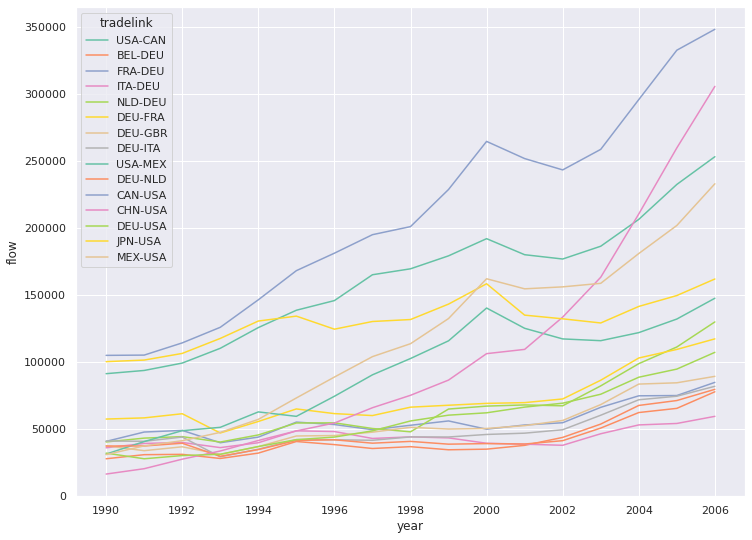

In [58]:
# Tradeflows across top 10 tradelinks with highest average trade volume over time

sns.lineplot(x='year',y='flow', hue='tradelink', data=largest_tradelinks.query('year >= 1990'), palette='Set2')

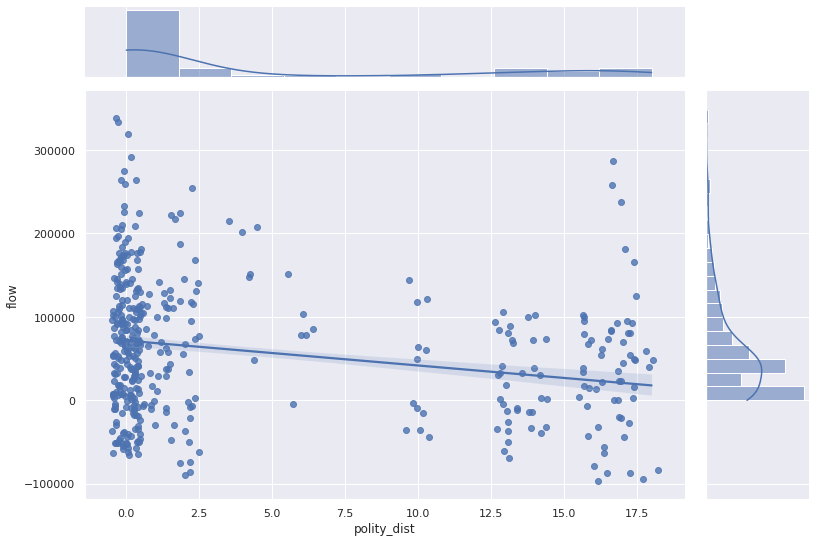

In [59]:
# Joint point of polity distance and tradeflow

grid = sns.jointplot(x='polity_dist', y='flow', kind='reg', palette='Set2', x_jitter=0.5, y_jitter=100000, data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)

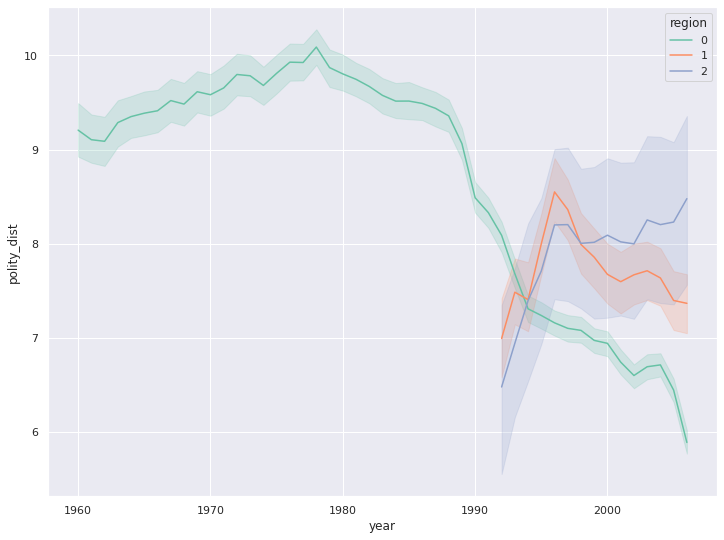

In [56]:
# Change in polity distance over time
# Dataset of former Soviet countries as the origin from 1960-2006

FORMER_SOVIET_COUNTRIES = {
    "Estonia": "EST",
    "Latvia": "LVA",
    "Lithuania": "LTU",
    "Kazakhstan": "KAZ",
    "Kyrgyzstan": "KGZ",
    "Tajikistan": "TJK",
    "Turkmenistan": "TKM",
    "Uzbekistan": "UZB",
    "Belarus": "BLR",
    "Moldova": "MDA",
    "Ukraine": "UKR",
    "Russia": "RUS",
    "Armenia": "ARM",
    "Azerbaijan": "AZE",
    "Georgia": "GEO"
}


def label_region(country):
    if country in FORMER_SOVIET_COUNTRIES.values():
        return 1
    else:
        return 0
    
polity_data['region_o'] = polity_data['iso_o'].apply(lambda country: label_region(country))
polity_data['region_d'] = polity_data['iso_d'].apply(lambda country: label_region(country))
polity_data['region'] = polity_data['region_o'] + polity_data['region_d']
grid = sns.lineplot(x='year', y='polity_dist', hue='region', palette='Set2', 
                    data=polity_data)

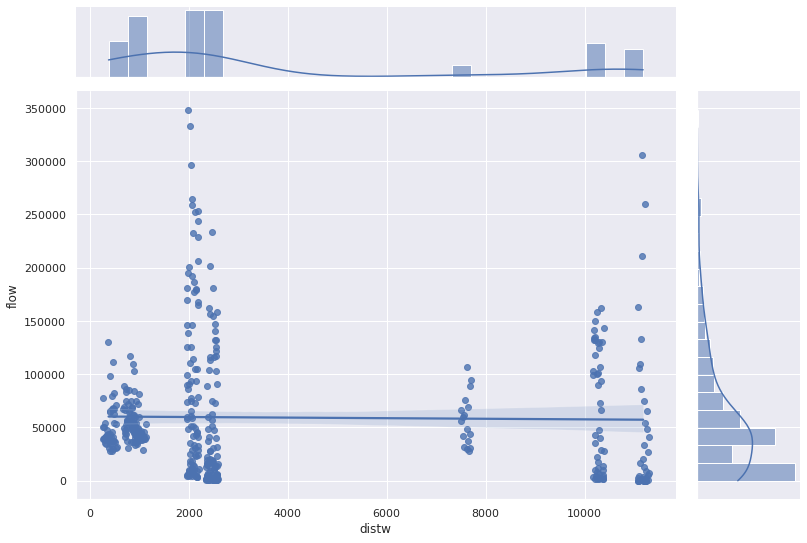

In [62]:
# Relationship between distance and flow

grid = sns.jointplot(x='distw',y='flow', kind='reg',palette='Set2',x_jitter=120, data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)

## 3. Results
---

## 4. Comments
---